<a href="https://colab.research.google.com/github/wanderingxplorer1/ml-projects/blob/main/amazon-book-reviews/AmazonBookReviewsFineTuneBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Book Reviews
Predicting the review rating of a book using reviews/ratings to train a DNN.
The dataset can be found in https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews

In [ ]:
!pip install -q --upgrade keras-nlp
!pip install -q --upgrade keras  # Upgrade to Keras 3.

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras_nlp
import keras
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Use mixed precision to speed up all training in this guide.
keras.mixed_precision.set_global_policy("mixed_float16")

# Download the data
We will be using the Amazon book reviews dataset to create a model to predict
the rating of a book given it's review.

The dataset can be found in https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
! mkdir ~/.kaggle
! cp /content/gdrive/MyDrive/Kaggle/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d mohamedbakhet/amazon-books-reviews

amazon-books-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip amazon-books-reviews.zip
book_ratings_csv = "/content/Books_rating.csv"

Archive:  amazon-books-reviews.zip
replace Books_rating.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace books_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# Prepare the dataset
The dataset is very unbalanced. Most of the ratings are 4 or 5 stars.
In order to balance it, we will create 5 datasets, one for each review rating
and then combine them. We will sample each dataset with equal probablity
to create the final dataset.

Also, the ratings are floats from 1.0 5.0. We will map them to integers from
0-4 so that we can use them as labels for a sparse_categorical_crossentropy loss
so that we don't to one-hot encode them.

In [ ]:
BATCH_SIZE = 32
TRAIN_SIZE = 128000
VAL_SIZE = 12800
TEST_SIZE = 12800

dataset = tf.data.experimental.make_csv_dataset(book_ratings_csv,
                                                batch_size=BATCH_SIZE,
                                                select_columns=["review/summary", "review/score"],
                                                label_name="review/score")
dataset1 = dataset.unbatch().filter(lambda x, y : tf.equal(y, 1.0))
dataset2 = dataset.unbatch().filter(lambda x, y : tf.equal(y, 2.0))
dataset3 = dataset.unbatch().filter(lambda x, y : tf.equal(y, 3.0))
dataset4 = dataset.unbatch().filter(lambda x, y : tf.equal(y, 4.0))
dataset5 = dataset.unbatch().filter(lambda x, y : tf.equal(y, 5.0))

books_dataset = tf.data.Dataset.sample_from_datasets(
    [dataset1, dataset2, dataset3, dataset4, dataset5], stop_on_empty_dataset=True)

# Extract out the review from the OrderedDict.
# Change labels from 1.0-5.0 to 0-4 so that we can use them as labels without
# have to one-hot encode them.
books_dataset = books_dataset.map(lambda x, y : (x['review/summary'], int(y)-1))
train_ds = books_dataset.take(TRAIN_SIZE).batch(BATCH_SIZE)
val_ds = books_dataset.take(VAL_SIZE).batch(BATCH_SIZE)
test_ds = books_dataset.take(TEST_SIZE).batch(BATCH_SIZE)

for batch in test_ds.take(1):
  print(batch)

(<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'Yet another post-apocalyptic tale...',
       b'Marshall Hollenzer is Driving', b'tough going',
       b'Does not match picture.',
       b"This book is good but I wouldn't call it great.",
       b'Pseudo-nihilistic garbage. A waste of paper and ink.',
       b'Not Good Enough', b'Turn on to this radio book.',
       b'The Scarlet Letter', b'Frankenstein is NO Odd Thomas',
       b'Nasty book, nasty woman', b'weak advice', b'Great classic',
       b'Intimate Enemy, Images and Voices of the Rwandan Genocide',
       b'nice eye candy, but not as handy as the other guides',
       b'Startlingly overrated (in my opinion, anyway)', b'tough going',
       b'I really liked this book', b'Scary Stories',
       b'We could all use a little plain and simple in our lives.',
       b"I'm gonna get blasted for this, but...",
       b"Reveiw on Jack Kerovac's The Dharma Bums",
       b"Stephen Gammel's illustrations are creepy and haunting -- l

In [ ]:
classifier = keras_nlp.models.BertClassifier.from_preset("bert_tiny_en_uncased", num_classes=5)
# Note: batched inputs expected so must wrap string in iterable
classifier.predict(["A FAST PACED , FIRST RATE MUST READ STORY!!!"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[ 0.2483  , -0.1147  , -0.005833,  0.1311  ,  0.01778 ]],
      dtype=float16)

In [ ]:
classifier.evaluate(test_ds)

400/400 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 1.6133 - sparse_categorical_accuracy: 0.1999


[1.6131274700164795, 0.20250000059604645]

In [ ]:
history = classifier.fit(train_ds, validation_data=[val_ds], epochs=40)

Epoch 1/40
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 146s 28ms/step - loss: 1.4215 - sparse_categorical_accuracy: 0.3674 - val_loss: 1.2850 - val_sparse_categorical_accuracy: 0.4447
Epoch 2/40
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 141s 35ms/step - loss: 1.2426 - sparse_categorical_accuracy: 0.4621 - val_loss: 1.2305 - val_sparse_categorical_accuracy: 0.4727
Epoch 3/40
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 132s 33ms/step - loss: 1.1932 - sparse_categorical_accuracy: 0.4863 - val_loss: 1.1986 - val_sparse_categorical_accuracy: 0.4913
Epoch 4/40
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 142s 35ms/step - loss: 1.1535 - sparse_categorical_accuracy: 0.5061 - val_loss: 1.1738 - val_sparse_categorical_accuracy: 0.5047
Epoch 5/40
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 132s 33ms/step - loss: 1.1213 - sparse_categorical_accuracy: 0.5243 - val_loss: 1.1454 - val_sparse_categorical_accuracy: 0.5274
Epoch 6/40
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 112s 28ms/step - loss: 1.0921 - sparse_categorical_accuracy: 0.5400 - val_loss: 1.1142 - val_sparse_cat

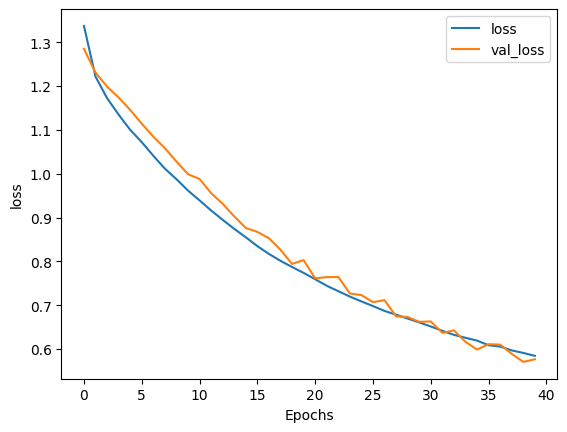

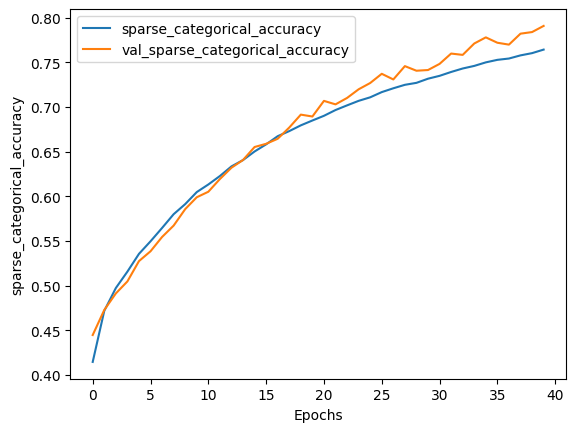

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "loss")
plot_graphs(history, "sparse_categorical_accuracy")

In [ ]:
classifier.predict(["A FAST PACED , FIRST RATE MUST READ STORY!!!"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


array([[-3.629, -2.443, -0.446,  2.041,  4.4  ]], dtype=float16)

In [ ]:
classifier.evaluate(test_ds)

400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.5406 - sparse_categorical_accuracy: 0.7955


[0.5740461349487305, 0.7928906083106995]

In [ ]:
classifier.save('amazon_book_reviews.keras')

In [ ]:
amazon_model = tf.keras.models.load_model('amazon_book_reviews.keras')


/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:727: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 88 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 84 variables. 
  trackable.load_own_variables(weights_store.get(inner_pa

In [ ]:
amazon_model.predict(["A FAST PACED , FIRST RATE MUST READ STORY!!!"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[-3.629, -2.443, -0.446,  2.041,  4.4  ]], dtype=float16)